# NYC-Taxi-FHV-Project


In [141]:
import pandas as pd
import numpy as np
import os
from math import sin, cos, sqrt, atan2, radians, log
import time
import matplotlib.pyplot as plt
import datetime
import holidays
import urllib        #for url stuff
import re            #for processing regular expressions
from sklearn.cluster import KMeans # for doing K-means clustering
import seaborn as sns #for making plots
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
import geopandas as gpd
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
import geopandas as gpd
import geohash_hilbert as ghh
import choroplethNYC as cp

pd.set_option('display.max_columns', 500)
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYU-Taxi-project/My First Project-b3735f3b3a9d.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="D:/Projects/NYC-Taxi-FHV-Project/My First Project-b3735f3b3a9d.json"
from google.cloud import bigquery
client = bigquery.Client()

import geopandas as gpd
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
import geopandas as gpd
import geohash_hilbert as ghh
import choroplethNYC as cp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline
output_notebook()

Loading BokehJS ...

## Query Data from BigQuery

In [75]:
start = time.time()
query = (
"""
SELECT travel_time, date_of_year, month_of_year, day_of_year, pickup_hour,
    dropoff_datetime,pickup_datetime,
    pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,
    temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date_of_year, pickup_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude,
            EXTRACT (HOUR FROM pickup_datetime) as pickup_hour,
            EXTRACT (DAY FROM pickup_datetime) as day_of_year,
            EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
            EXTRACT (DATE FROM pickup_datetime) as date_of_year,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time,
            passenger_count
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and
                dropoff_longitude IS NOT NULL and dropoff_latitude IS NOT NULL
      ) x
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) y on x.month_of_year = y.month and x.day_of_year = y.day
where x.row_number <= 30
"""
)
data=pd.io.gbq.read_gbq(query,dialect='standard')
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Time taken by above cell is 0.9566284855206807.


## Feature Engineering

In [76]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = round(2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)),3)
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

# create distance_in_km
data['distance_in_km'] = haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

# create mahattan dist
data['mahattan_distance'] = manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

# create bearing
data['bearing'] = bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

# create weekday
data["weekday"] = data['pickup_datetime'].dt.dayofweek

# create travel time
data['travel_time'] = round(data['travel_time'], 2)

# create holiday
us_holidays = holidays.UnitedStates()
data['holiday'] = data['date_of_year'].apply(lambda x: 1 if x in us_holidays else 0)

# create geo hash (clustering the pickup and dropoff spots)
pickup = []
dropoff = []
for i in range(len(data)):
    pickup.append(ghh.encode(data.pickup_longitude.iloc[i], data.pickup_latitude.iloc[i], precision=5))
    dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))

data['pickup_geo'] = pickup
data['dropoff_geo'] = dropoff


data['pickup_geo'] = data['pickup_geo'].astype('category').cat.codes
data["dropoff_geo"] = data["dropoff_geo"].astype('category').cat.codes

## Optimize the memory usage

In [77]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

Original memory usage:  79.20 MB
After converting int and float memory usage:  15.85 MB


## Process Missing Data & Outlier

### Weather Data Cleaning

In [78]:
# refill visib using forward or backward
data['visib'] = data['visib'].replace(999.9, np.nan).fillna(method='ffill')

# refill mxpsd using forward or backward
data['mxpsd'] = data['mxpsd'].replace(999.9, np.nan).fillna(method='ffill')              

# refill wdsp using forward or backward
data['wdsp'] = data['wdsp'].replace(999.9, np.nan).fillna(method='ffill')              

# refill gust as 0
data.loc[(data['gust'] == 999.9), 'gust'] = 0

# refit sndp as 0
data.loc[data['sndp'] == 999.9, 'sndp'] = 0

### Taxi Data cleaning

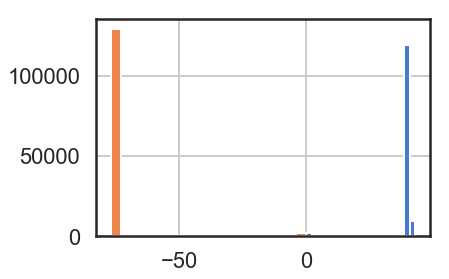

In [79]:
data['pickup_latitude'].hist(bins=20)
data['pickup_longitude'].hist(bins=20)

# remove any pickup not in the manha
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
data = data[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1])]
data = data[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1])]
data = data[(data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1])]
data = data[(data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1])]

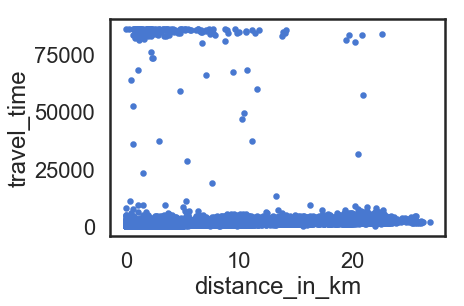

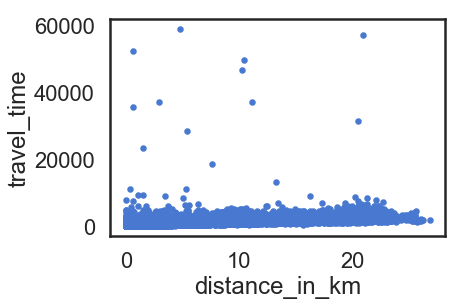

In [80]:
# remove duration is over 1000 mins, and distance is far away 50 km
data.plot(x='distance_in_km',y='travel_time',kind='scatter')

data = data[(data['travel_time']>0) & (data['distance_in_km']<50)  & (data['travel_time']<60000)]

data.plot(x='distance_in_km',y='travel_time',kind='scatter')

## Exploratory Data Analysis

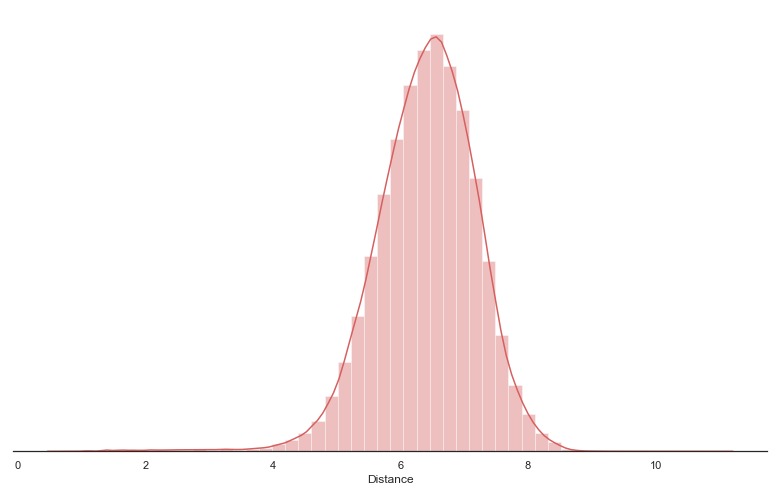

In [81]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(data['travel_time'].values+1), axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

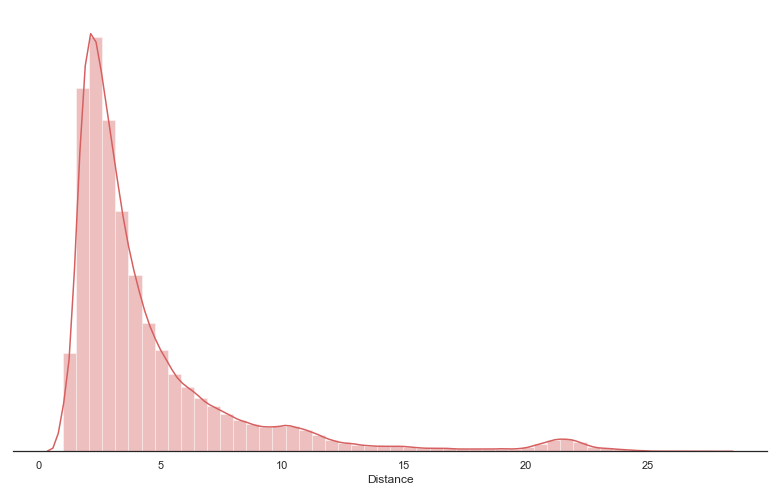

In [82]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(data['distance_in_km'].values+1, axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


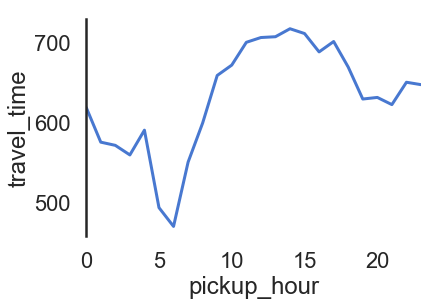

In [83]:
summary_hour_duration = pd.DataFrame(data.groupby('pickup_hour')['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", value="travel_time")
sns.despine(bottom = True)

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


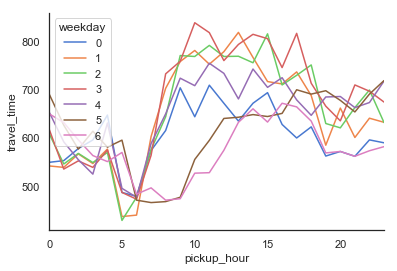

In [93]:
summary_hour_duration = pd.DataFrame(data.groupby(['weekday','pickup_hour'])['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="weekday", value="travel_time")
sns.despine(bottom = False)

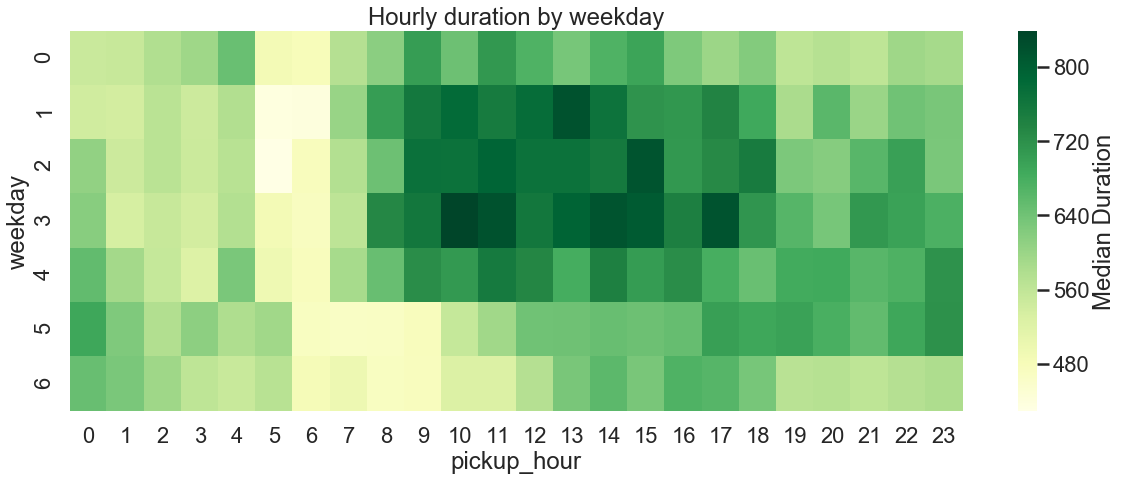

In [85]:
heatmap_data1 = summary_hour_duration.pivot(index = 'weekday',columns = 'pickup_hour',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
sns.heatmap(heatmap_data1, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

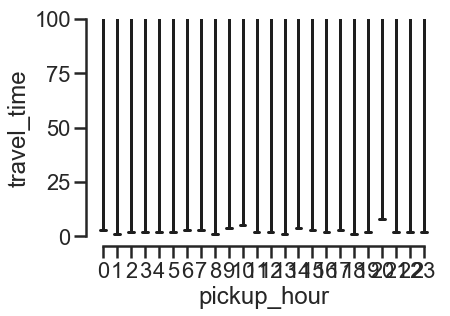

In [86]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="pickup_hour", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 100)
sns.despine(offset=10, trim=True)


### Weekly Durations

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


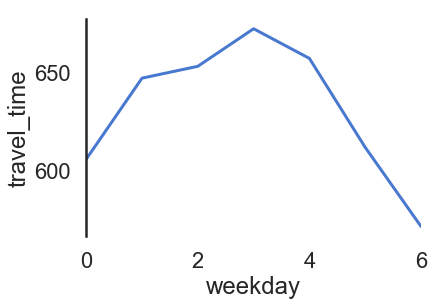

In [87]:
summary_week_duration = pd.DataFrame(data.groupby(['weekday'])['travel_time'].median())
summary_week_duration.reset_index(inplace = True)
summary_week_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_week_duration, time="weekday", unit = "unit", value="travel_time")
sns.despine(bottom = True)

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


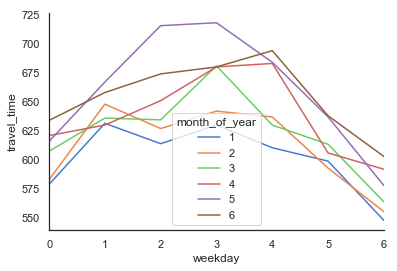

In [94]:
summary_weekday_duration = pd.DataFrame(data.groupby(['weekday','month_of_year'])['travel_time'].median())
summary_weekday_duration.reset_index(inplace = True)
summary_weekday_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
# sns.set_context("poster")
sns.tsplot(data=summary_weekday_duration, time="weekday", unit = "unit", condition="month_of_year", value="travel_time")
sns.despine(bottom = False)

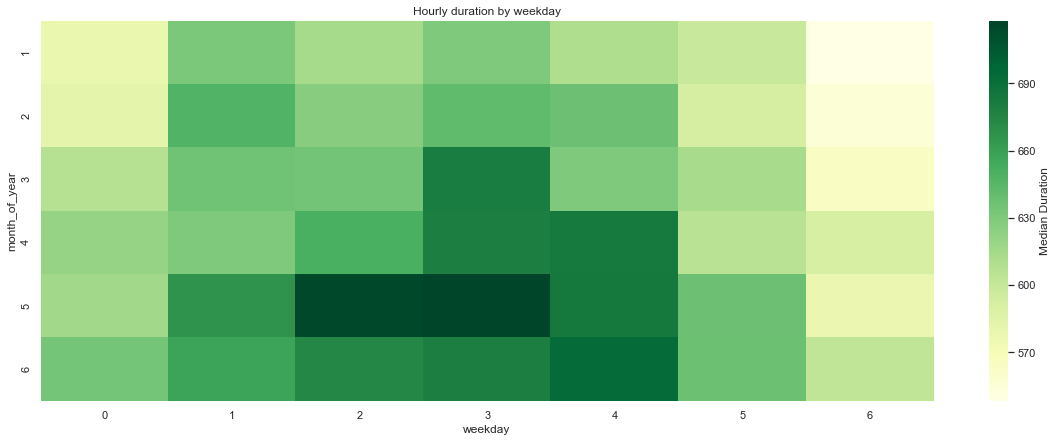

In [97]:
heatmap_data2 = summary_weekday_duration.pivot(index = 'month_of_year',columns = 'weekday',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
ax.axis
sns.heatmap(heatmap_data2, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

59201
Time taken by above cell is 0.06586027145385742.


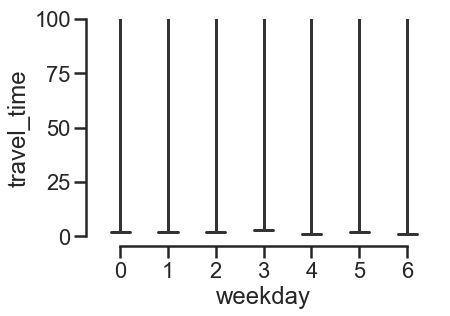

In [98]:
start = time.time()
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="weekday", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 100)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

### Monthly Durations

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


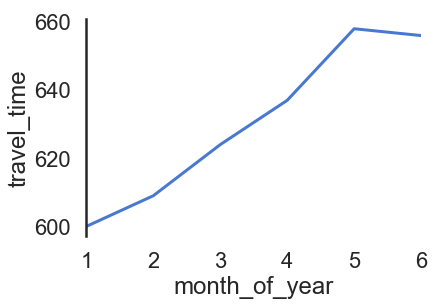

In [99]:
summary_month_duration = pd.DataFrame(data.groupby(['month_of_year'])['travel_time'].median())
summary_month_duration.reset_index(inplace = True)
summary_month_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_month_duration, time="month_of_year", unit = "unit", value="travel_time")
sns.despine(bottom = True)

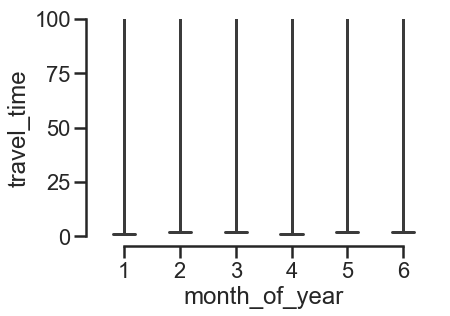

In [100]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="month_of_year", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 100)
sns.despine(offset=10, trim=True)

### Passenger count

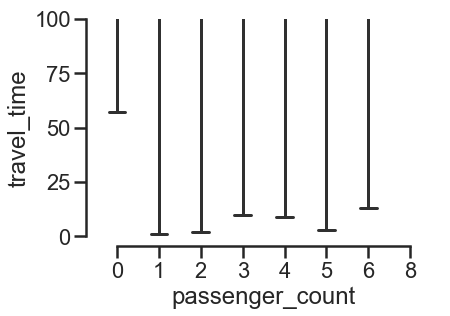

In [101]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="passenger_count", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 100)
sns.despine(offset=10, trim=True)

### Create Dummy

In [ ]:
data_month = pd.get_dummies(data['month_of_year'])
data_month.columns = ['month_' + str(col) for col in data_month.columns]

data_hour = pd.get_dummies(data['pickup_hour'])
data_hour.columns = ['hour_' + str(col) for col in data_hour.columns]

data_day = pd.get_dummies(data['day_of_year'])
data_day.columns = ['day_' + str(col) for col in data_day.columns]

# 0 for Monday
data_week = pd.get_dummies(data['weekday'])
data_week.columns = ['week_' + str(col) for col in data_week.columns]

data = pd.concat([data, data_month, data_week, data_day, data_hour], axis=1)

#### K-Means Cluster

In [113]:
start = time.time()

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

location = data.loc[:, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

kmeans = KMeans(n_clusters=100, random_state=123, n_init = 10, n_jobs = 4).fit(location)
location['label'] = kmeans.labels_

data['locationID'] = location['label']

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Time taken by above cell is 1.367574441432953.


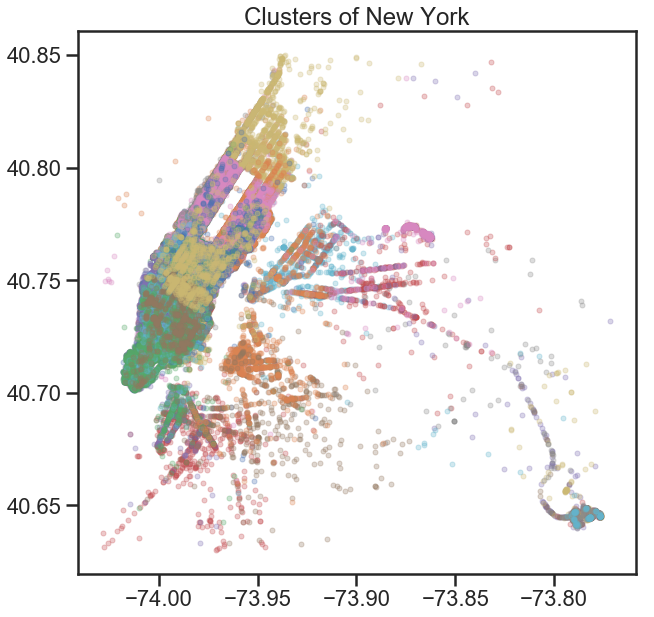

In [103]:
plt.figure(figsize = (10,10))
for label in location.label.unique():
    plt.plot(location.pickup_longitude[location.label == label],location.pickup_latitude[location.label == label],'.', alpha = 0.3, markersize = 10)

plt.title('Clusters of New York')
plt.show()

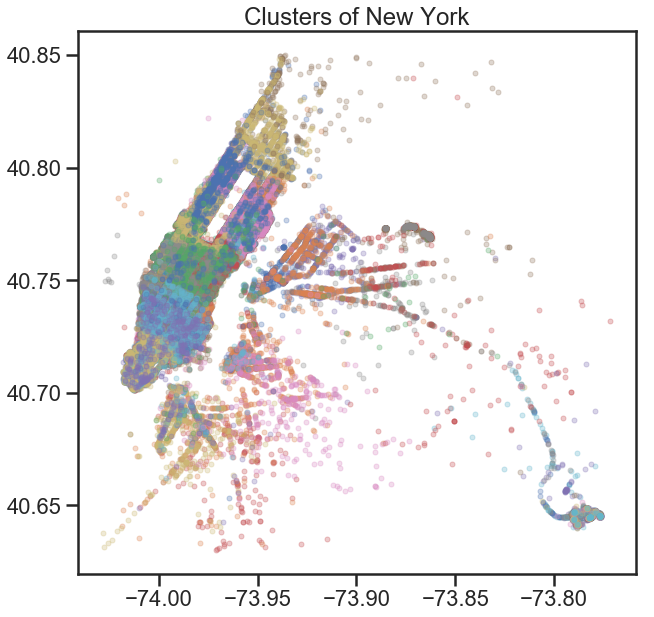

In [114]:
plt.figure(figsize = (10,10))
for label in location.label.unique():
    plt.plot(location.pickup_longitude[location.label == label],location.pickup_latitude[location.label == label],'.', alpha = 0.3, markersize = 10)

plt.title('Clusters of New York')
plt.show()

## Modeling

### Split Training and Test

In [115]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'locationID',
       'dropoff_latitude', 'passenger_count', 'pickup_geo', 'dropoff_geo', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'mahattan_distance','distance_in_km']

x = data[selected_features]
y = np.log(data['travel_time'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [106]:
def train_test_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    print(clf)
    # Make prediction on the training data
    y_train_pred = clf.predict(x_train)

    # Make predictions on test data
    y_test_pred = clf.predict(x_test)
    
    # Evaluate
    R2_Train = clf.score(x_train,y_train)
    R2_Test = clf.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
    RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
    RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE','RMSLE']
    metric_values_train = [R2_Train, RMSE_Train, RMSLE_Train]
    metric_values_test = [R2_Test, RMSE_Test, RMSLE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

### Random Forest

In [116]:
start = time.time()
parameters = {'n_estimators': 500,
             'max_features': 'auto',
              'max_depth': 20,
              'min_samples_split': 50,
              'random_state': 2,
              'n_jobs': -1
              }

rf = RandomForestRegressor(**parameters)
train_test_model_performance(rf)

# print("R2:", round(rf.score(x_test,y_test),3))
# print("MSE:", round(mean_squared_error(y_test, rf.predict(x_test)),3))
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

# RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
#            max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=30,
#            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
#            oob_score=False, random_state=123, verbose=0, warm_start=False)
# 0.88, 0.7932

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=50,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)
            train      test
metrics                    
R2       0.838168  0.767700
RMSE     0.318870  0.380382
RMSLE    0.051873  0.061145
Time taken by above cell is 0.9414345820744833.


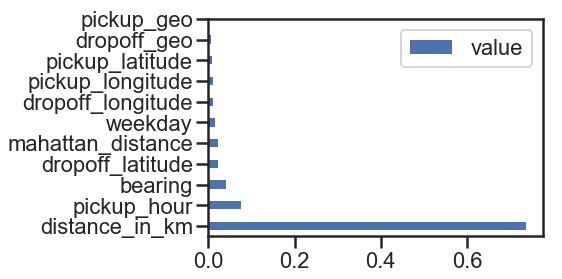

In [117]:
features = pd.DataFrame(list(zip(selected_features, rf.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Gradient Boosting Trees

In [134]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 150,
    'max_depth': 3,
    'learning_rate': 0.2,
    'min_samples_split': 30,
    'max_features': 'sqrt',
    'subsample': 0.7,
    'random_state': 2
}

GBDT = GradientBoostingRegressor(**parameters)
train_test_model_performance(GBDT)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=30,
             min_weight_fraction_leaf=0.0, n_estimators=150,
             n_iter_no_change=None, presort='auto', random_state=2,
             subsample=0.7, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
            train      test
metrics                    
R2       0.771992  0.760398
RMSE     0.378492  0.386314
RMSLE    0.059642  0.061817
Time taken by above cell is 0.07544056574503581.


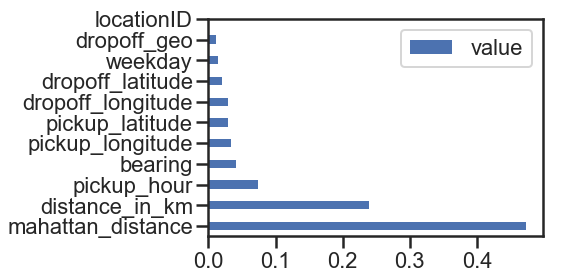

In [135]:
features = pd.DataFrame(list(zip(selected_features, GBDT.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### XGB

In [136]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [145]:
xgb_pars = {'min_child_weight': 15, 'eta': 0.1, 'colsample_bytree': 0.7,
            'max_depth': 10, 'subsample': 0.7, 'alpha': 8, 'lambda':1, 'nthread': -1, 'booster': 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
xgb_model = xgb.train(xgb_pars, dtrain, 150, watchlist, early_stopping_rounds=3,
      maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:5.36295	valid-rmse:5.36613
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 3 rounds.
[1]	train-rmse:4.83128	valid-rmse:4.83425
[2]	train-rmse:4.35325	valid-rmse:4.35602
[3]	train-rmse:3.92348	valid-rmse:3.92602
[4]	train-rmse:3.53719	valid-rmse:3.53945
[5]	train-rmse:3.19007	valid-rmse:3.19211
[6]	train-rmse:2.87846	valid-rmse:2.88026
[7]	train-rmse:2.59901	valid-rmse:2.60062
[8]	train-rmse:2.34764	valid-rmse:2.34902
[9]	train-rmse:2.1219	valid-rmse:2.12309
[10]	train-rmse:1.92026	valid-rmse:1.92134
[11]	train-rmse:1.74066	valid-rmse:1.74166
[12]	train-rmse:1.57869	valid-rmse:1.57957
[13]	train-rmse:1.43359	valid-rmse:1.43434
[14]	train-rmse:1.30444	valid-rmse:1.3051
[15]	train-rmse:1.18963	valid-rmse:1.1903
[16]	train-rmse:1.08713	valid-rmse:1.0877
[17]	train-rmse:0.995578	valid-rmse:0.996102
[18]	train-rmse:0.914732	valid-rmse:0.915375
[19]	train-rmse:0.843647	valid-rmse:0.844415
[20]

r2: 0.7199741173275164
rmse: 0.3641071824452361
r2: 0.7733727655106551


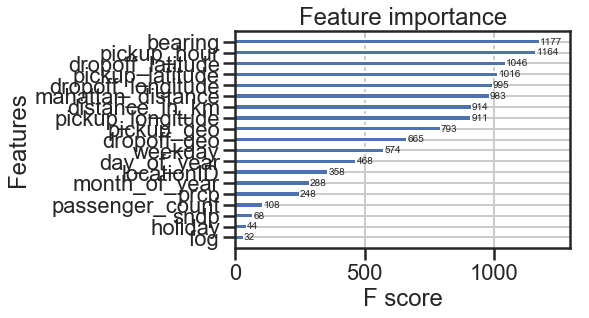

In [146]:
xgb.plot_importance(xgb_model, max_num_features=28, height=0.5)

pred = xgb_model.predict(dvalid)
print("r2:", r2_score(pred, y_test))
print("rmse:",sqrt(mean_squared_error(pred,y_test)))
print("r2:", r2_score(xgb_model.predict(dtrain), y_train))

### HyperParameter Tuning: Grid Search

In [147]:
def cv_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    model = clf.best_estimator_
    print(model)
    
    # Make prediction on the training data
    y_train_pred = model.predict(x_train)

    # Make predictions on test data
    y_test_pred = model.predict(x_test)
    
    # Evaluate
    R2_Train = model.score(x_train,y_train)
    R2_Test = model.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
    RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
    RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE','RMSLE']
    metric_values_train = [R2_Train, RMSE_Train, RMSLE_Train]
    metric_values_test = [R2_Test, RMSE_Test, RMSLE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

### RF

In [31]:
start = time.time()

# Choose the type of classifier. 
rf = RandomForestRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [400, 500], 
              'max_features': ['auto'], 
              'max_depth': [25,30,35], 
              'min_samples_split': [20,35],
              'n_jobs':[-1]
             }

# read theory
grid_obj = GridSearchCV(rf, param_grid, cv=3, n_jobs = 8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [400, 500, 600], 'max_features': ['auto'], 'max_depth': [25, 30, 35], 'min_samples_leaf': [2, 5, 7, 10], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
            train      test
metrics                    
R2       0.937195  0.678010
RMSE     0.160038  0.363526
RMSLE    0.030191  0.063487
Time taken by above cell is 79.01845415830613.


### GBDT

In [ ]:
start = time.time()
GBDT = GradientBoostingRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [150, 170], 
              'max_depth': [8,9,10], 
              'learning_rate': [0.3]
             }

# read theory
grid_obj = GridSearchCV(GBDT, param_grid, cv=3, n_jobs=6, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

# print("R2: ", round(GBDT_cv.score(x_test,y_test),4))
# print("MSE:", round(mean_squared_error(y_test, GBDT_cv.predict(x_test)),4))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

## Testing

In [ ]:
testing = pd.read_csv("./Data/APM4990_final_test_data_filtered.csv")

